## Simple Neural Process implementation

based on https://chrisorm.github.io/NGP.html

Comments on original implementation:
- Too few samples (5 data points?!)
- No meta-learning: only a single sin() function is learnt
- Decoder std output is hard-coded and thus can't be learned
- Z is sampled a fixed number of times for each each pass

Changes:
- Decoder std output (as opposed to hard-coding it)
- Replace Softplus() function in ZEncoder with sigmoid

ToDo:
- combine both encoders (and aggregation step)
- return distribution from ZEncoder()
- Decoder input is 128 + 1: very imbalaced?

Orginal Deepmind implementation:
- Garnelo paper stated to have 3-layer MLP as encoder and 5-layer MLP as decoder but not in implementation

In [180]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import watermark
import plotly.graph_objects as go

import collections


In [181]:
class REncoder(torch.nn.Module):
    """Encodes inputs of the form (x_i, y_i) into representations, r_i.
    Implemented with 4 hidden layers and 128 hidden units each.
    ReLu activations.
    """
    
    def __init__(self, in_dim, r_dim):
        super(REncoder, self).__init__()
        self.hidden_dim = 128
        
        # Layers
        self.l1 = torch.nn.Linear(in_dim, self.hidden_dim)
        self.l2 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l3 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l4 = torch.nn.Linear(self.hidden_dim, r_dim)
    
        self.a = torch.nn.ReLU()

    def forward(self, inputs):
        x = self.a(self.l1(inputs))
        x = self.a(self.l2(x))
        x = self.a(self.l3(x))
        # No activation in last layer (as in Garnelo implementation)
        r_i = self.l4(x)

        return r_i
    
class ZEncoder(torch.nn.Module):
    """Takes an r_agg representation and produces the mean & standard deviation of the 
    normally distributed function encoding, z."""
    def __init__(self, r_dim, out_dim):
        super(ZEncoder, self).__init__()
        self.mu_size = out_dim
        self.sigma_size = out_dim
        
        # Linear layers to latent mu and sigma
        self.mu = torch.nn.Linear(r_dim, self.mu_size)
        # log_sigma
        self.sigmoid_argument = torch.nn.Linear(r_dim, self.sigma_size)

        # Constrain sigma with sigmoid layer
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inputs):
        # Enforces sigma (standard deviation) to be between 0 and 1
        return self.mu(inputs), self.sigmoid(self.sigmoid_argument(inputs))
        # Garnelo: sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)
    

class Decoder(torch.nn.Module):
    """
    Takes the x* points, along with a 'function encoding', z, and makes predictions.
    """
    def __init__(self, in_dim, out_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = 128
        
        # Layers
        self.l1 = torch.nn.Linear(in_dim, self.hidden_dim)
        self.l2 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l3 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l4 = torch.nn.Linear(self.hidden_dim, out_dim)
    
        # sigmoid or Relu activation
        self.a = torch.nn.ReLU()

    def forward(self, x_target, z):
        """
        x_target: [n target points, x_dim]
        z: [m samples, z_dim (= r_dim)]
        """
        # Unsqueeze adds explicit first dimension [1, , ]. Expand expands (created m copies) along the first dimension [m, , ] ([m, n, x_dim])
        x_target_reshaped = x_target.unsqueeze(0).expand(z.shape[0], x_target.shape[0], x_target.shape[1])
        # Unsqueeze adds explicit last dimension [ , , 1]. Expands expands (created n copies) along the last diemnsion [ , , n] ([m, r_dim, n])
        # Transpose(1, 2) switches dimensionalities [m, n, r_dim]
        zs_reshaped = z.unsqueeze(-1).expand(z.shape[0], z.shape[1], x_target.shape[0]).transpose(1, 2)
        
        # concatinates along last (third) dim: 128 + 1
        xz = torch.cat([x_target_reshaped, zs_reshaped], dim = 2)

        xz = self.a(self.l1(xz))
        xz = self.a(self.l2(xz))
        xz = self.a(self.l3(xz))
        # No activation in last layer
        y = self.l4(xz)

        # squeeze removes the explicit last dimension of dim = 1 
        # Fixed std??
        return y.squeeze(-1).transpose(0, 1), 0.005
        
        
def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim = 0).mean()

def KLD_gaussian(mu_q, std_q, mu_p, std_p):
    """Analytical KLD between 2 Gaussians."""
    qs2 = std_q**2 + 1e-16
    ps2 = std_p**2 + 1e-16
    
    return (qs2/ps2 + ((mu_q-mu_p)**2)/ps2 + torch.log(ps2/qs2) - 1.0).sum()*0.5

In [182]:
# bottleneck
r_dim = 128
z_dim = 128

x_dim = 1
y_dim = 1

n_z_samples = 10 # number of samples for Monte Carlo expecation of log likelihood

r_encoder = REncoder(x_dim + y_dim, r_dim) # (x,y) -> r
z_encoder = ZEncoder(r_dim, z_dim) # r -> mu, std
decoder = Decoder(x_dim + z_dim, y_dim) # (x*, z) -> y*

opt = torch.optim.Adam(list(decoder.parameters()) + list(z_encoder.parameters()) + list(r_encoder.parameters()), 1e-3)

# Before training

Shape of x_grid: torch.Size([80, 1])
z_dim: 128
Shape of random, untrained z's: torch.Size([30, 128])


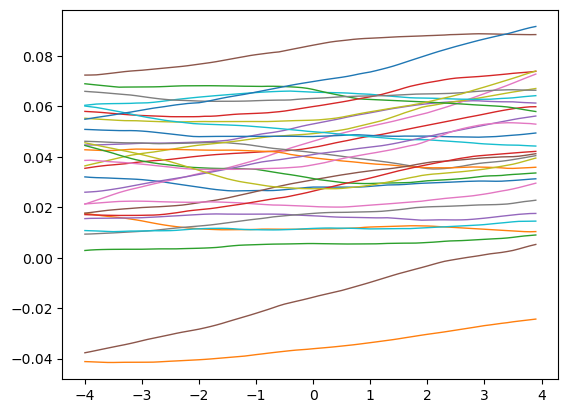

In [183]:
x_grid = torch.from_numpy(np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32))
print(f"Shape of x_grid: {x_grid.size()}")

# Draw 30 random latent vectors z
untrained_zs = torch.from_numpy(np.random.normal(size = (30, z_dim)).astype(np.float32))
print(f"z_dim: {z_dim}")
print(f"Shape of random, untrained z's: {untrained_zs.shape}")

# Pass through decoder to visualise the prior (means only)
mu, _ = decoder(x_grid, untrained_zs)

# For all 30 z's (and same x_grid) output 30 mean lines
for i in range(mu.shape[1]):
    plt.plot(x_grid.data.numpy(), mu[:, i].data.numpy(), linewidth = 1)
plt.show()

In [184]:
def random_split_context_target(x, y, n_context):
    """Helper function to split randomly into context and target"""
    ind = np.arange(x.shape[0])
    mask = np.random.choice(ind, size = n_context, replace = False)
    # complementing sets
    return x[mask], y[mask], np.delete(x, mask, axis = 0), np.delete(y, mask, axis = 0)

def sample_z(mu, std, n):
    """Reparameterisation trick."""
    eps = torch.autograd.Variable(std.data.new(n, z_dim).normal_())
    return mu + std * eps

def data_to_z_params(x, y):
    """Helper to batch together some steps of the process."""
    # Concatenate along second dimension (columns). [n, 1], [n, 1] -> [n, 2]
    xy = torch.cat([x, y], dim = 1)
    # Produces an r_dim-dimensional encoding for all datapairs xy
    rs = r_encoder(xy)
    # Average over n
    r_agg = rs.mean(dim = 0) # Average over samples
    # Returns tuple of r_dim-diemnsional mu and r_dim-dimensional sigma
    return z_encoder(r_agg) # Get mean and variance for q(z|...)

def visualise(x, y, x_star):
    z_mu, z_std = data_to_z_params(x,y)
    # sampling 100 different realisations from z (all r_dim long)
    zsamples = sample_z(z_mu, z_std, 100)
    
    mu, _ = decoder(x_star, zsamples)
    for i in range(mu.shape[1]):
        # draw samples based on 100 different z_samples
        plt.plot(x_star.data.numpy(), mu[:,i].data.numpy(), linewidth=1)
    plt.scatter(x.data.numpy(), y.data.numpy())
    plt.show()

In [193]:
# Span only a portion of the space
all_x_np = np.arange(-2, 3, 0.1).reshape(-1, 1).astype(np.float32)
# Add noise
all_y_np = np.sin(all_x_np) + torch.rand(size = all_x_np.shape).numpy()/10

In [194]:
def train(n_epochs, n_display = 3000):
    losses = []
    for t in range(n_epochs): 
        opt.zero_grad()

        # Generate data and process
        x_context, y_context, x_target, y_target = random_split_context_target(
                                all_x_np, all_y_np, np.random.randint(1, 40))
        
        x_c = torch.from_numpy(x_context)
        x_t = torch.from_numpy(x_target)
        y_c = torch.from_numpy(y_context)
        y_t = torch.from_numpy(y_target)

        x_ct = torch.cat([x_c, x_t], dim=0)
        y_ct = torch.cat([y_c, y_t], dim=0)

        # Get latent variables for target and context, and for context only.
        z_mean_all, z_std_all = data_to_z_params(x_ct, y_ct)
        z_mean_context, z_std_context = data_to_z_params(x_c, y_c)
        
        # Sample a batch of zs using reparam trick.
        zs = sample_z(z_mean_all, z_std_all, n_z_samples)

        # DECODER
        mu, std = decoder(x_t, zs) # Get the predictive distribution of y*
        # Compute loss and backprop
        loss = -log_likelihood(mu, std, y_t) + KLD_gaussian(z_mean_all, z_std_all,
                                                            z_mean_context, z_std_context)
        losses.append(loss)
        loss.backward()
        opt.step()

        if t % n_display == 0:
            print(f"Function samples after {t} steps:")
            x_g = torch.from_numpy(np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32))
            visualise(x_ct, y_ct, x_g)
    return losses

Function samples after 0 steps:


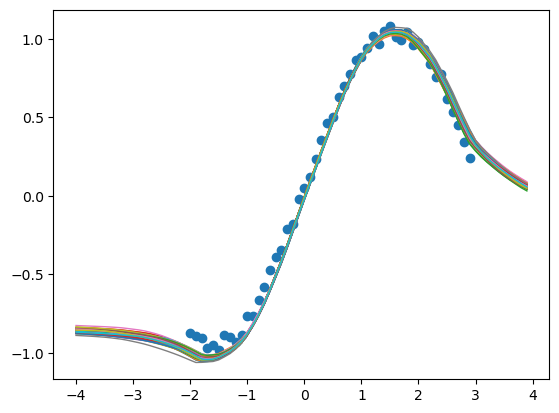

Function samples after 3000 steps:


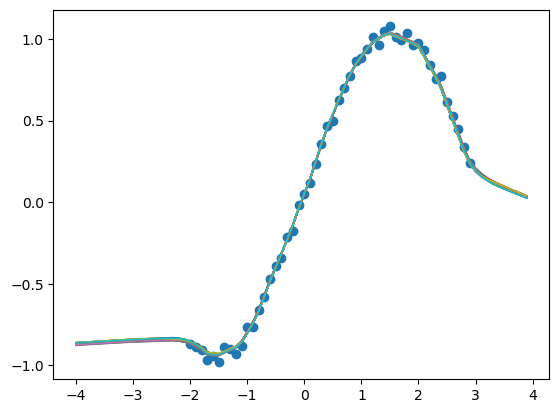

Function samples after 6000 steps:


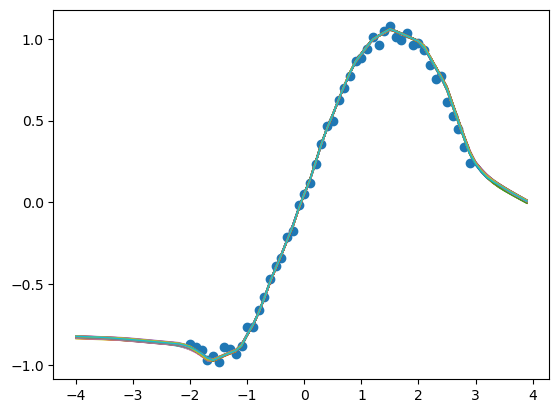

Function samples after 9000 steps:


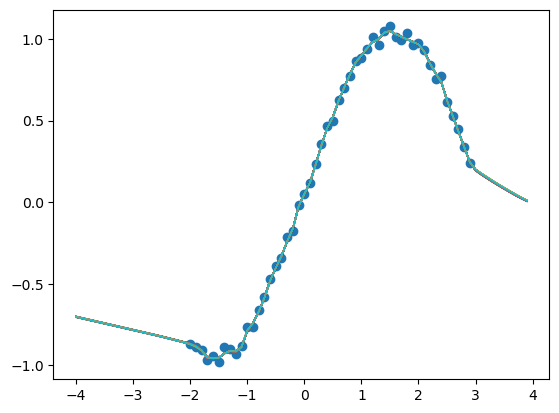

[tensor(556.3844, grad_fn=<AddBackward0>),
 tensor(4779.7026, grad_fn=<AddBackward0>),
 tensor(1177.2239, grad_fn=<AddBackward0>),
 tensor(4221.2363, grad_fn=<AddBackward0>),
 tensor(827.3698, grad_fn=<AddBackward0>),
 tensor(2936.3042, grad_fn=<AddBackward0>),
 tensor(1714.6915, grad_fn=<AddBackward0>),
 tensor(653.0496, grad_fn=<AddBackward0>),
 tensor(1220.8524, grad_fn=<AddBackward0>),
 tensor(1840.8490, grad_fn=<AddBackward0>),
 tensor(613.1550, grad_fn=<AddBackward0>),
 tensor(2937.6985, grad_fn=<AddBackward0>),
 tensor(1157.3619, grad_fn=<AddBackward0>),
 tensor(1871.1238, grad_fn=<AddBackward0>),
 tensor(1373.7955, grad_fn=<AddBackward0>),
 tensor(756.3201, grad_fn=<AddBackward0>),
 tensor(2506.2129, grad_fn=<AddBackward0>),
 tensor(572.4130, grad_fn=<AddBackward0>),
 tensor(1491.6519, grad_fn=<AddBackward0>),
 tensor(358.4397, grad_fn=<AddBackward0>),
 tensor(842.7606, grad_fn=<AddBackward0>),
 tensor(1389.7828, grad_fn=<AddBackward0>),
 tensor(2223.7549, grad_fn=<AddBackward0

In [195]:
train(9001)